In [1]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Release')
sys.path.insert(0, 'D:/pascucci/ppt/2022/6_NASA/idx2/build/Source/Python/RelWithDebInfo')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import os
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures
import threading

path_prefix = 'J:/nasa/'
if not os.path.exists (path_prefix): 
  path_prefix = "W:/cedmav/hello/"

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -1
vmax = 1

C:\Users\Duong\AppData\Local\Temp\ipykernel_16300\1642366175.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Set up color map

In [2]:
import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


# Some helper functions

In [3]:
def get_file_name(input_dir, dataset, field, time):
  return input_dir + '/' + dataset + '/' + field + '-time-' + repr(time) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    return (0, 0, 0, 4320 * 4, 4320 * 3, 90)
  return (0, 0, 0, 2160 * 4, 2160 * 3, 90)

# Query 
# extent should be a 4-tuple: (from_x, from_y, from_depth, dim_x, dim_y, dim_depth)
def query_data(input_dir, dataset, field, time, downsampling, accuracy, extent=None):  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  x = e0[0]
  y = e0[1]
  d = e0[2]
  dx = e0[3]
  dy = e0[4]
  dd = e0[5]
  dx0 = dx//2
  dx1 = dx-dx0
  dy0 = dy//2
  dy1 = dy-dy0
  e1 = (x    , y    , d, dx0, dy0, dd)
  e2 = (x+dx0, y    , d, dx1, dy0, dd)
  e3 = (x    , y+dy0, d, dx0, dy1, dd)
  e4 = (x+dx0, y+dy0, d, dx1, dy1, dd)

  file = get_file_name(input_dir, dataset, field, time)
    
  array = None
  if dx < 16 or dy < 16: # if too small, don't spawn threads
    array = i2p.DecodeExtent3f32(file, input_dir, extent, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape, dtype=float)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

# Introducing the data

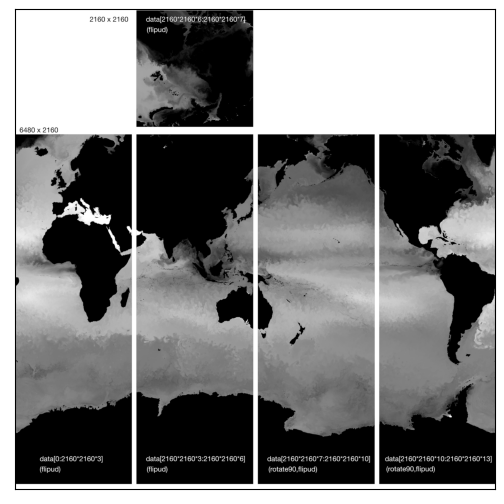

In [4]:
%matplotlib inline
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img = mpimg.imread(path_prefix + 'MITgcm_lat_lon_cap_facets.png')
ax.imshow(img)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.show()

# Visualize four faces for llc2160 (32 time steps)

<IPython.core.display.Javascript object>


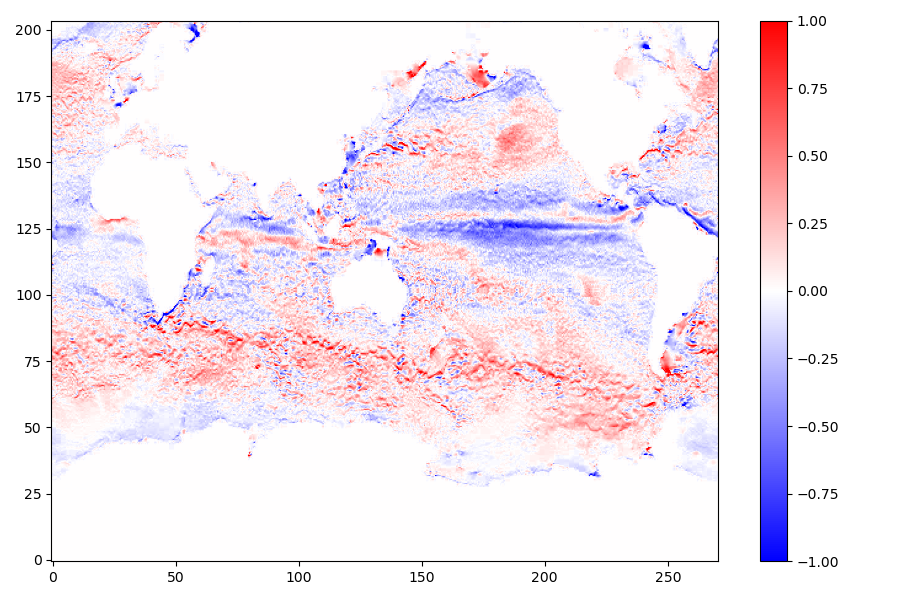

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='1000px'), max=29), Output()), _…

interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='1000px'), max=89), Output()), _…

CPU times: total: 1.83 s
Wall time: 581 ms


In [8]:
%%time

%matplotlib notebook
input_dir = path_prefix
dataset = 'llc2160_x_y_depth'
field = 'u'
depth = 0
time = 0
extent = (0, 0, 0, 2160 * 4, 2160 * 3, 90)
accuracy = 1

ds_time  = [4, 4, 2] # if going through time, we can afford to downsample heavily in other axes
ds_depth = [3, 3, 0] # to scroll through depths, we keep depth at high resolution
array = query_data(input_dir, dataset, field, time, ds_time, accuracy, extent)

fig = plt.figure(figsize = (9, 6))
plot = plt.imshow(array[0, ::2, ::2], origin = 'lower', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax)
plt.colorbar(plot)
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
fig.tight_layout()

begin = True
  
def change_depth(d):
  global depth, begin
  if begin:
    begin = False
    return
  depth = d
  plot.set_data(array[d//pow(2,ds_time[2]), :, :])

def change_time(t):
  global time, depth, begin
  if begin:
    begin = False
    return
  time = t
  array = query_data(input_dir, dataset, field, time, ds_time, accuracy, extent)
  plot.set_data(array[depth//pow(2,ds_time[2]), :, :])

interact(change_time, t = widgets.IntSlider(min=0, max=29, step=1, value=0, layout=Layout(width='1000px')));
interact(change_depth, d = widgets.IntSlider(min=0, max=89, step=1, value=0, layout=Layout(width='1000px')));

begin = False